In [1]:
import win32com.client
import pandas as pd
import numpy as np
import math

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import brentq

from ema_workbench.analysis import parcoords
from ema_workbench import load_results
from ema_workbench.analysis import feature_scoring

C:\Users\nlilbm\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:21: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn(
C:\Users\nlilbm\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


In [2]:
results = load_results('250 scenarios 4 policies.tar.gz')
experiments, outcomes = results
outcomes['car_total'] = outcomes['carshare_km'] * outcomes['totaal_km']

In [3]:
policies = experiments['policy']
scenarios = experiments['scenario']

data = pd.DataFrame(outcomes)
data['policy'] = policies
data['scenario'] = scenarios

# Minimax regret + feature scoring or regret

In [4]:
var_of_int = 'car_total'

In [5]:
data['regret'] = 0

for i in range(250):
    lowest = min(list([data[var_of_int][i], data[var_of_int][i+250],
              data[var_of_int][i+500], data[var_of_int][i+750]]))
    for j in list([0, 250, 500, 750]):
        data.loc[i+j,'regret'] = data.loc[i+j, var_of_int] - lowest

In [6]:
minimax_regret = {'basecase':0,'fiets':0,'30 km':0,'parkeren':0}
for i in minimax_regret.keys():
    tmp = data[data['policy']==i]
    minimax_regret[i] = tmp['regret'].max()

In [15]:
minimax_regret

{'basecase': 32913.52128446236,
 'fiets': 0.0,
 '30 km': 32679.18994876492,
 'parkeren': 9962.291173006932}

In [7]:
outcomes['regret'] = data.loc[:,'regret']

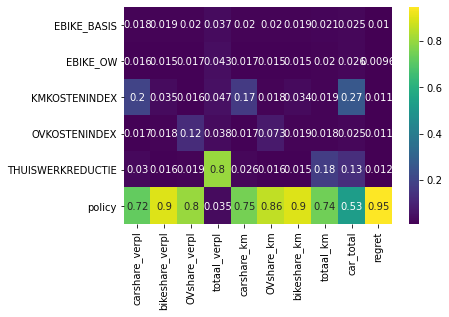

In [8]:
x = experiments.drop('model_file', axis=1)
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

In [30]:
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

x = experiments.drop('model_file', axis=1)
y = outcomes['regret'].array

scores = feature_scoring.get_ex_feature_scores(x, y,
                                      max_features=2, mode=RuleInductionType.REGRESSION)[0]
scores.round(2)

,1
0,
policy,0.95
KMKOSTENINDEX,0.01
THUISWERKREDUCTIE,0.01
OVKOSTENINDEX,0.01
EBIKE_OW,0.01
EBIKE_BASIS,0.01


# 90 percentile minimax regret

In [16]:
var_of_int = 'car_total'

In [17]:
data['regret'] = 0

for i in range(250):
    lowest = min(list([data[var_of_int][i], data[var_of_int][i+250],
              data[var_of_int][i+500], data[var_of_int][i+750]]))
    for j in list([0, 250, 500, 750]):
        data.loc[i+j,'regret'] = data.loc[i+j, var_of_int] - lowest

In [18]:
per_90_minimax_regret = {'basecase':0,'fiets':0,'30 km':0,'parkeren':0}
for i in per_90_minimax_regret.keys():
    tmp = data[data['policy']==i].sort_values('regret')
    per_90_minimax_regret[i] = tmp['regret'].iloc[225]

In [19]:
per_90_minimax_regret

{'basecase': 32309.054610598483,
 'fiets': 0.0,
 '30 km': 32079.6884023936,
 'parkeren': 8938.579275015625}

# Maximax

In [20]:
maximax = {'basecase':0,'fiets':0,'30 km':0,'parkeren':0}
for i in maximax.keys():
    tmp = data[data['policy']==i]
    maximax[i] = tmp[var_of_int].min()

In [21]:
maximax

{'basecase': 299818.2905336969,
 'fiets': 270099.9012326239,
 '30 km': 299604.4269080591,
 'parkeren': 278142.0951897874}

# Mean-variance

In [23]:
mean_variance = {'basecase':0,'fiets':0,'30 km':0,'parkeren':0}
for i in mean_variance.keys():
    tmp = data[data['policy']==i]
    mean_variance[i] = tmp[var_of_int].mean() * tmp[var_of_int].std()
    print(tmp[var_of_int].std(), tmp[var_of_int].mean())

13038.071809508489 324692.8883099089
12305.045713606485 293509.0821120493
13033.536913270806 324469.2016142682
11793.760331833308 301057.497274464


In [24]:
mean_variance

{'basecase': 4233369193.8213115,
 'fiets': 3611642672.747446,
 '30 km': 4228981316.4590716,
 'parkeren': 3550599968.956588}

# Starr's domain criterium

In [25]:
carshare_km = outcomes['car_total']
carshare_km.sort()
median = carshare_km[500]
median

310903.0319233194

In [26]:
Starr = {'basecase':0,'fiets':0,'30 km':0,'parkeren':0}

for i in Starr.keys():
    tmp = data[data['policy']==i]
    tmp = tmp.reset_index()
    n = 0
    for j in range(len(tmp)):
        if tmp.loc[j,var_of_int] < median:
            n += 1
    Starr[i] = n
    
Starr

{'basecase': 39, 'fiets': 222, '30 km': 40, 'parkeren': 199}

In [27]:
policies_robust = {'carshare_km':[],'OVshare_km':[],'bikeshare_km':[],'totaal_km':[]}

robust = {}

for i in policies.unique():
    poli = data[data.policy == i]
    for j in policies_robust:
        n = 0
        for k in poli.index:
            n += poli[j].max() - poli.loc[k,j]
        policies_robust[j].append(n)

In [28]:
policies_robust = pd.DataFrame.from_dict(policies_robust)
policies_robust

,carshare_km,OVshare_km,bikeshare_km,totaal_km
0,2.968039,1.233487,2.624991,1.298978e+07
1,2.706487,1.008698,2.448488,1.364980e+07
2,2.967068,1.232042,2.623146,1.299097e+07
3,2.699243,1.224901,2.428192,1.308727e+07


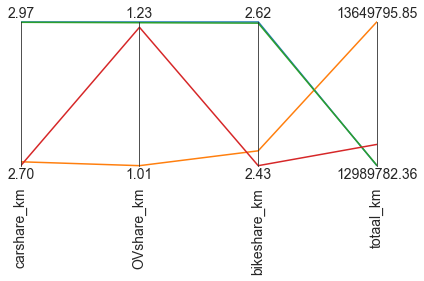

In [29]:
limits = parcoords.get_limits(policies_robust)
#limits.loc[0, :] = 0
#limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(policies_robust)
plt.show()